In [1]:
####Dynamic Linear Regression model####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import calendar
import statsmodels
import statsmodels.api as sm
from datetime import datetime
from datetime import timedelta
from scipy import sparse
from scipy.stats import norm
from numpy.random import *
from scipy import optimize

np.random.seed(98537)

In [2]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, pattern):
    if pattern==1:
        z_id = np.array(np.argmax(np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis], axis=1), dtype="int")
        Z = np.diag(np.repeat(1, k))[z_id, ]
        return z_id, Z
    z_id = np.array(np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1), dtype="int")
    return z_id
    
#連続した日付を取得する関数
def daterange(_start, _end):
    for n in range((_end - _start).days):
        yield _start + timedelta(n)

In [3]:
####シミュレーションデータを生成####
##日付データを作成
#対象期間の日付と曜日情報を出力
start = datetime.strptime('2014-01-01', '%Y-%m-%d')
end   = datetime.strptime('2019-09-30', '%Y-%m-%d')
get_date = np.array([])
day_of_week = np.array([], dtype="int")
for day in daterange(start, end):
    get_date = np.append(get_date, day)
    day_of_week = np.append(day_of_week, day.weekday())
    
#日付を定義
Timestamp = pd.Series(get_date)
date = pd.DataFrame({"date": Timestamp.astype("U")})
date_df = pd.merge(date, pd.DataFrame({"date": np.unique(date), "date_id": np.arange(date.shape[0])}), on="date", how="inner")
year = pd.DataFrame({"year": Timestamp.astype("U").str[:4]})
unique_year = np.unique(year)
year_df = pd.merge(year, pd.DataFrame({"year": unique_year, "year_id": np.arange(unique_year.shape[0])}), on="year", how="inner")
month = pd.DataFrame({"month": Timestamp.astype("U").str[:7]})
unique_month = np.unique(month)
month_df = pd.merge(month, pd.DataFrame({"month": unique_month, "month_id": np.arange(unique_month.shape[0])}), on="month", how="inner")

#週を定義
freq = pd.Series(day_of_week).value_counts()
argmax_week = freq.index[np.argmax(np.array(freq))]
index = np.array(np.where(day_of_week==0)[0], dtype="int")
if np.min(index)!=0:
    index = np.append(0, index)
if np.max(index)!=day_of_week.shape[0]-1:
    index = np.append(index, day_of_week.shape[0])
weeks = index.shape[0] - 1
week = np.repeat(0, day_of_week.shape[0])
for i in range(weeks):
    if i==0:
        get = np.arange(index[i], index[i+1])
        week[get] = np.repeat(i, get.shape[0])
    else:
        get = np.arange(index[i], index[i+1])
        week[get] = np.repeat(i, get.shape[0])
        
#データフレームを作成
calendar_df = pd.concat((date_df[["date"]], year_df, month_df, pd.DataFrame({"week_id": week, "day_of_week": day_of_week})), axis=1)
calendar_df["month_index"] = calendar_df["month"].str[5:7].astype("int")

In [4]:
##データの生成
#データの定義
days = calendar_df["date"].shape[0]
weeks = np.unique(calendar_df["day_of_week"]).shape[0]
months = np.unique(calendar_df["month_index"]).shape[0]

In [5]:
#周期成分を生成
week = np.array(np.eye(weeks), dtype="int")[np.array(calendar_df["day_of_week"]), 1:]
month = np.array(np.eye(months), dtype="int")[np.array(calendar_df["month_index"])-1, 1:]
Z = np.hstack((np.random.beta(2.5, 5.0, days)[:, np.newaxis], np.random.beta(4.0, 3.0, days)[:, np.newaxis])) 
k = week.shape[1] + month.shape[1] + 1

#週成分の制約インデックスを定義
week_allocation = [i for i in range(days)]
for i in range(days):
    if i <= weeks-1:
        week_allocation[i] = np.sort(np.arange(0, i))[::-1]
    else:
        week_allocation[i] = np.sort(np.arange(days)[i-weeks+1:i])[::-1]

In [6]:
##静的および動的パラメータを生成
#状態パラメータ
s = 5
S1 = np.array([0.05, 0.15, 0.6, 0.15, 0.05])
S2 = np.array([[0.82, 0.11, 0.06, 0.01, 0.01],
               [0.11, 0.79, 0.07, 0.02, 0.01],
               [0.01, 0.02, 0.95, 0.02, 0.01],
               [0.01, 0.02, 0.07, 0.79, 0.11],
               [0.01, 0.01, 0.06, 0.11, 0.82]])

#状態推移を生成
z = np.repeat(0, days)
for i in range(days):
    if i==0:
        z[i] = np.argmax(np.random.multinomial(1, S1, 1))
    else:
        z[i] = np.argmax(np.random.multinomial(1, S2[z[i-1], ], 1))
        
#初期値の設定
tau = np.array([0.01, 0.005, 0.01, 0.0025, 0.0025])
trend = np.append(np.random.normal(0, tau[0], 1), np.repeat(0.0, days-1))
ar = np.append(np.random.normal(0, 0.05, 1), np.repeat(0.0, days-1))
seasonal = np.append(np.random.normal(0, 0.3, weeks), np.repeat(0.0, days-weeks))
theta = np.vstack((np.random.normal(0, 0.2, Z.shape[1]), np.zeros((days-1, Z.shape[1]))))

#時間ごとにパラメータを生成
for i in range(1, days):
    diff_trend = np.sort(np.random.normal(0, tau[0], s))
    trend[i] = trend[i-1] + diff_trend[z[i-1]]
    ar[i] = ar[i-1] + np.random.normal(0, tau[1], 1)
    theta[i, ] = theta[i-1, ] + np.random.multivariate_normal(np.repeat(0.0, Z.shape[1]), np.diag(tau[3:]), 1)
    if i >= weeks-1:
        seasonal[i] = np.sum(-seasonal[week_allocation[i]]) + np.random.normal(0, tau[2], 1)
        
#静的パラメータを生成
Sigma = np.array([0.5])
beta = np.random.normal(0, 0.3, months-1)
Sigmat = Sigma.copy(); betat = beta.copy()

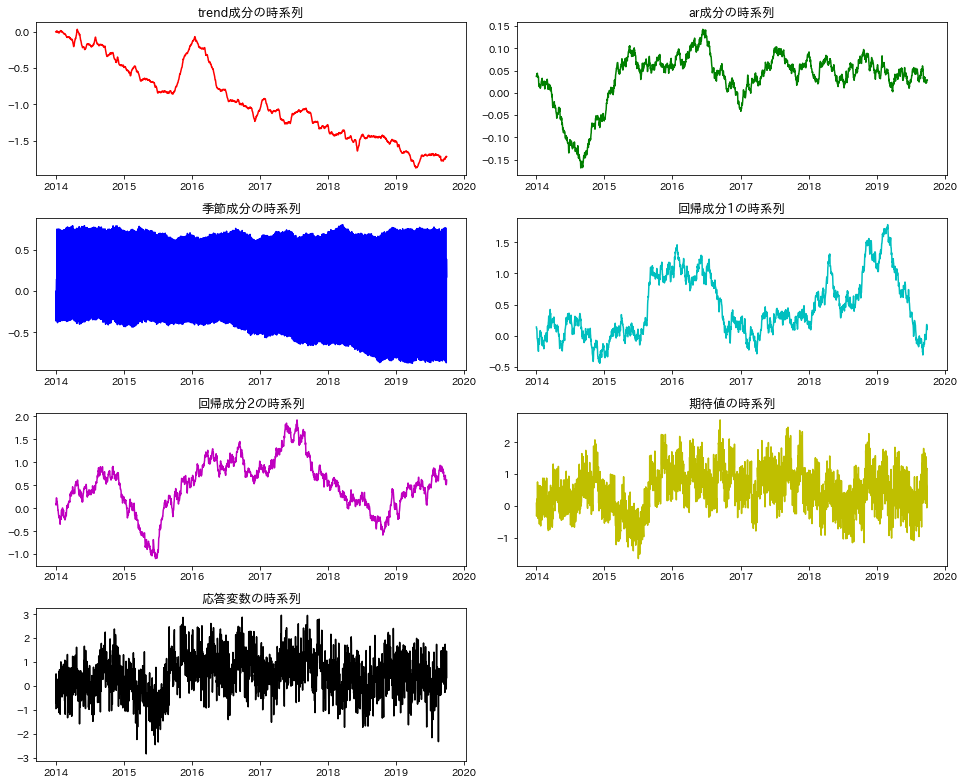

In [9]:
##応答変数を生成
#日時での動的変数を生成
y = np.repeat(0.0, days)
mu = np.repeat(0.0, days)
for i in range(days):
    if i==0:
        mu[i] = seasonal[i] + np.dot(Z[i, ], theta[i, ])
    else:
        mu[i] = ar[i]*y[i-1] + seasonal[i] + np.dot(Z[i, ], theta[i, ])
        
    #正規分布から応答変数を生成
    mu[i] += np.dot(month[i, ], beta)
    y[i] = mu[i] + np.random.normal(0, Sigma, 1)
    
#データフレームを作成
datetime = np.array(date, dtype="datetime64[D]").reshape(-1)
df = pd.DataFrame({"日付": datetime, "応答変数": y, "期待値": mu, "trend成分": trend, "ar成分": ar, "季節成分": seasonal,
                   "回帰成分1": theta[:, 0], "回帰成分2": theta[:, 1]})
df.index = np.array(date, dtype="datetime64[D]").reshape(-1)

#生成したパラメータとデータの可視化
dt = [df["trend成分"], df["ar成分"], df["季節成分"], df["回帰成分1"], df["回帰成分2"], df["期待値"], df["応答変数"]]
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["trend成分の時系列", "ar成分の時系列", "季節成分の時系列", "回帰成分1の時系列", "回帰成分2の時系列", 
          "期待値の時系列", "応答変数の時系列"]
fig = plt.figure(figsize=(13.5, 11.0))
for j in range(len(dt)):
    ax = fig.add_subplot(4, 2, j+1)
    ax.plot(dt[j], color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

In [26]:
####カルマンフィルターで動的回帰モデルを推定####
##カルマンフィルタを計算する関数
#カルマンフィルタを逐次計算する関数
def KF(beta, Sigma, y, Z, H, x, V, Q, F, G, days):
    
    #モデル誤差を定義
    er = y - np.dot(Z, beta)
    trend_days = np.repeat(0.0, days)
    VF_list = [i for i in range(days)]
    V_list = [i for i in range(days)]
    
    for i in range(days):
        #1期先予測
        Fx = np.dot(F, x)
        VF = np.dot(np.dot(F, V), F.T) + np.dot(np.dot(G, tau*Q), G.T)

        #フィルタリング
        index = np.array([i])
        HVH = np.dot(np.dot(H[index, ], VF), H[index, ].T) + np.power(Sigma, 2)
        inv_HVH = np.linalg.inv(HVH)
        K = np.dot(np.dot(VF, H[index, ].T), inv_HVH)   #カルマンゲイン
        new_x = x + np.dot(K, er[i] - np.dot(H[i, ], x)).reshape(-1)
        new_V = VF - np.dot(np.dot(K, H[index, ]), VF)

        #パラメータの更新
        x = new_x.copy()
        V = new_V.copy()
        trend_days[i] = x
        VF_list[i] = VF
        V_list[i] = new_V
    return trend_days, VF_list, V_list

#カルマンフィルタの対数尤度
def loglike(beta, Sigma, y, Z, H, x, V, Q, F, G, days):

    #モデル誤差を定義
    trend_days = np.repeat(0.0, days)
    Kal = np.repeat(0.0, days)
    er = y - np.dot(Z, beta)

    for i in range(days):
        #1期先予測
        Fx = np.dot(F, x)
        VF = np.dot(np.dot(F, V), F.T) + np.dot(np.dot(G, tau*Q), G.T)

        #フィルタリング
        index = np.array([i])
        HVH = np.dot(np.dot(H[index, ], VF), H[index, ].T) + np.power(Sigma, 2)
        inv_HVH = np.linalg.inv(HVH)
        K = np.dot(np.dot(VF, H[index, ].T), inv_HVH)   #カルマンゲイン
        new_x = x + np.dot(K, er[i] - np.dot(H[i, ], x)).reshape(-1)
        new_V = VF - np.dot(np.dot(K, H[index, ]), VF)

        #パラメータの更新
        x = new_x.copy()
        V = new_V.copy()
        trend_days[i] = x
        mu = x + np.dot(Z[i, ], beta)
        Kal[i] = np.log(np.linalg.det(HVH)) + np.dot(np.dot(y[i] - mu, inv_HVH), y[i] - mu)

    #対数尤度の和
    Lho = -1/2 * (days*np.log(2*np.pi) + np.sum(Kal))
    return -Lho

In [27]:
##静的パラメータの初期値を設定
#3次回期のパラメータを推定
d = np.array(np.arange(days)/days)[:, np.newaxis]
D = np.hstack((np.repeat(1.0, days)[:, np.newaxis], d, np.power(d, 2), np.power(d, 3), 
               np.append(0, y[:days-1])[:, np.newaxis], Z, week, month))
xy = np.dot(D.T, y)
inv_xx = np.linalg.inv(np.dot(D.T, D))
alpha = np.dot(inv_xx, xy)

#静的パラメータを定義
beta = alpha[(D.shape[1]-(months-1)):]
Sigma = np.sqrt(np.sum(np.power(y - np.dot(D, alpha), 2)) / days)
tau = np.array([0.01, 0.005, 0.005, 0.0025, 0.0025])

In [55]:
##準ニュートン法で静的パラメータを推定
#動的パラメータの初期値
par = tau.shape[0]
trend = np.mean(y[:20])
ar = 0.0
seasonal = np.random.normal(0, 0.1, 1)
theta = np.random.normal(0, 0.1, Z.shape[1])

#システムモデルの定義
index_week = np.arange(3, 3+weeks-1)
x = np.append(np.append(np.array([trend, ar]), np.random.normal(0, 0.05, weeks-1)), theta)
f = tau.shape[0]-1 + weeks - 1
F = np.zeros((f, f))
F[0, 0] = np.array([1.0])
F[1, 1] = np.array([1.0])
F[2:2+weeks-1, 2:2+weeks-1] = np.vstack((np.repeat(-1, weeks-1), np.diag(np.repeat(1.0, weeks-1))[:weeks-2]))
F[f-2:, f-2:] = np.diag(np.repeat(1.0, Z.shape[1]))
G = np.zeros((f, par))
G[0, 0] = np.array([1.0])
G[1, 1] = np.array([1.0])
G[2, 2] = np.array([1.0])
G[f-2:, 3:] = np.diag(np.repeat(1.0, Z.shape[1]))
V = np.diag(np.repeat(1.0, f))
Q = np.diag(np.repeat(1.0, par))
H = np.hstack((np.repeat(1.0, days)[:, np.newaxis], np.append(0.0, y[0:days-1])[:, np.newaxis], 
               np.repeat(1.0, days)[:, np.newaxis], np.zeros((days, weeks-2)), Z))

In [56]:
#モデル誤差を定義
er = y - np.dot(month, betat)
params = np.zeros((days, x.shape[0]))
VF_list = [i for i in range(days)]
V_list = [i for i in range(days)]

for i in range(days):
    #季節成分を更新
    if i > 1:
        seasonal_update = params[week_allocation[i], 2]
        x[index_week[np.arange(seasonal_update.shape[0])]] = seasonal_update
    
    #1期先予測
    Fx = np.dot(F, x)
    VF = np.dot(np.dot(F, V), F.T) + np.dot(np.dot(G, tau*Q), G.T)

    #フィルタリング
    index = np.array([i])
    HVH = np.dot(np.dot(H[index, ], VF), H[index, ].T) + np.power(Sigma, 2)
    inv_HVH = np.linalg.inv(HVH)
    K = np.dot(np.dot(VF, H[index, ].T), inv_HVH)   #カルマンゲイン
    new_x = x + np.dot(K, er[i] - np.dot(H[i, ], x)).reshape(-1)
    new_V = VF - np.dot(np.dot(K, H[index, ]), VF)
    
    #パラメータの更新
    x = new_x.copy()
    V = new_V.copy()
    params[i, ] = new_x
    VF_list[i] = VF
    V_list[i] = new_V

In [71]:
np.dot(VF, np.diag(np.repeat(1.0, f)))

array([[ 0.15264785, -0.03434514,  0.01557977, -0.02102377, -0.0011341 ,
        -0.00240574,  0.00963962, -0.00533846, -0.05239016, -0.09409417],
       [-0.03434514,  0.09874823, -0.0184091 ,  0.02593252,  0.00176315,
         0.00073545, -0.01415655,  0.00927362, -0.01326571, -0.00546856],
       [ 0.01557977, -0.0184091 ,  0.06534151, -0.02800462, -0.00692871,
        -0.00384658,  0.00198605, -0.00780347,  0.00184139, -0.00066536],
       [-0.02102377,  0.02593252, -0.02800462,  0.06439512, -0.01354379,
        -0.00445606, -0.01181865,  0.00031616,  0.00444184, -0.0019454 ],
       [-0.0011341 ,  0.00176315, -0.00692871, -0.01354379,  0.05124307,
        -0.0170794 , -0.00718192, -0.00305127,  0.00434565, -0.00733089],
       [-0.00240574,  0.00073545, -0.00384658, -0.00445606, -0.0170794 ,
         0.05019177, -0.01703115, -0.00439138, -0.0050229 ,  0.00612902],
       [ 0.00963962, -0.01415655,  0.00198605, -0.01181865, -0.00718192,
        -0.01703115,  0.05624894, -0.0188352 

In [72]:
VF

array([[ 0.15264785, -0.03434514,  0.01557977, -0.02102377, -0.0011341 ,
        -0.00240574,  0.00963962, -0.00533846, -0.05239016, -0.09409417],
       [-0.03434514,  0.09874823, -0.0184091 ,  0.02593252,  0.00176315,
         0.00073545, -0.01415655,  0.00927362, -0.01326571, -0.00546856],
       [ 0.01557977, -0.0184091 ,  0.06534151, -0.02800462, -0.00692871,
        -0.00384658,  0.00198605, -0.00780347,  0.00184139, -0.00066536],
       [-0.02102377,  0.02593252, -0.02800462,  0.06439512, -0.01354379,
        -0.00445606, -0.01181865,  0.00031616,  0.00444184, -0.0019454 ],
       [-0.0011341 ,  0.00176315, -0.00692871, -0.01354379,  0.05124307,
        -0.0170794 , -0.00718192, -0.00305127,  0.00434565, -0.00733089],
       [-0.00240574,  0.00073545, -0.00384658, -0.00445606, -0.0170794 ,
         0.05019177, -0.01703115, -0.00439138, -0.0050229 ,  0.00612902],
       [ 0.00963962, -0.01415655,  0.00198605, -0.01181865, -0.00718192,
        -0.01703115,  0.05624894, -0.0188352 

In [42]:
i = 11
#季節成分を更新
if i > 1:
    seasonal_update = params[week_allocation[i], 2]
    x[index_week[np.arange(seasonal_update.shape[0])]] = seasonal_update

#1期先予測
Fx = np.dot(F, x)
VF = np.dot(np.dot(F, V), F.T) + np.dot(np.dot(G, tau*Q), G.T)

#フィルタリング
index = np.array([i])
HVH = np.dot(np.dot(H[index, ], VF), H[index, ].T) + np.power(Sigma, 2)
inv_HVH = np.linalg.inv(HVH)
K = np.dot(np.dot(VF, H[index, ].T), inv_HVH)   #カルマンゲイン
new_x = x + np.dot(K, er[i] - np.dot(H[i, ], x)).reshape(-1)

In [44]:
np.diag()

array([[1.        , 0.27792763, 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.34200863, 0.78858576]])

In [30]:
i = 102
params[:, 2][np.append(week_allocation[i], week_allocation[i][0] + 1)]

array([0.17574877, 0.23199574, 0.20750485, 0.31404678, 0.30722351,
       0.27461596, 0.17351841])

In [63]:
Q

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [57]:
params_df = pd.DataFrame(params[:, np.array([0, 1, 2, 8, 9])] , index=datetime)
params_df.columns = ["trend成分推定", "ar成分推定", "季節成分推定", "回帰成分1推定", "回帰成分2推定"]
pd.concat((df, params_df), axis=1)

,日付,応答変数,期待値,trend成分,ar成分,季節成分,回帰成分1,回帰成分2,trend成分推定,ar成分推定,季節成分推定,回帰成分1推定,回帰成分2推定
2014-01-01,2014-01-01,-0.943571,0.088590,0.002150,0.036976,-0.002986,0.142049,0.094195,-0.287532,0.000000,-0.593295,-0.060560,-0.016835
2014-01-02,2014-01-02,0.504006,-0.315599,0.004950,0.039195,-0.361824,0.112313,0.069502,0.083198,-0.364557,-0.187579,0.103547,0.158840
2014-01-03,2014-01-03,-0.273278,-0.136650,0.002032,0.037259,-0.347190,0.112894,0.186371,0.049923,-0.403287,-0.239945,0.086777,0.130781
2014-01-04,2014-01-04,-0.718662,0.221591,0.005206,0.042614,0.018767,0.070120,0.226450,-0.048821,-0.365999,-0.639669,0.103167,-0.022193
2014-01-05,2014-01-05,0.196262,0.174523,0.012464,0.037742,0.147285,-0.040462,0.219130,0.048521,-0.463143,-0.332809,0.136906,-0.060182
2014-01-06,2014-01-06,-0.920382,-0.129536,0.013451,0.044212,-0.210475,-0.046263,0.207196,-0.058986,-0.541654,-0.656147,0.111064,-0.049737
2014-01-07,2014-01-07,-0.115681,0.756622,0.012897,0.039731,0.753338,-0.063366,0.094401,-0.037865,-0.590808,-0.521973,-0.610079,-0.033854
2014-01-08,2014-01-08,0.250748,0.023833,0.002603,0.039136,-0.023004,-0.095669,0.147184,-0.047899,-0.634861,-0.158188,-0.050905,0.054164
2014-01-09,2014-01-09,-0.038841,-0.257645,-0.007189,0.036429,-0.321610,-0.095295,0.086786,-0.001868,-0.532448,-0.040783,-0.305478,0.112768
2014-01-10,2014-01-10,-0.569830,-0.386655,-0.002865,0.036967,-0.382522,-0.160953,0.075213,-0.079376,-0.471036,-0.225072,-0.564686,0.134081


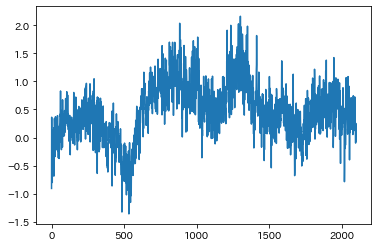

In [60]:
plt.plot(np.sum(H * params, axis=1))

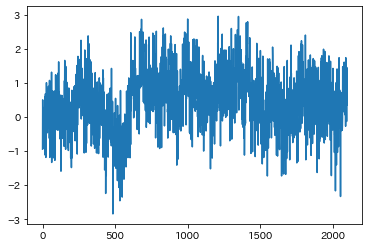

In [61]:
plt.plot(y)

In [323]:
np.dot(np.dot(G, tau*Q), G.T)
np.dot(np.dot(F, V), F.T)

array([[ 0.01 ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ],
       [ 0.   ,  0.05 ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.05 , -0.05 ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ],
       [ 0.   ,  0.   , -0.05 ,  0.05 ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.025,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.025]])